<a href="https://colab.research.google.com/github/Matias-Harper/Primer-Clasificador-de-imagenes-con-Python-y-Tensorflow/blob/main/Clasificador_de_im%C3%A1genes_Python_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clasificador de imagenes con Python y Tensorflow


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds 
#De los datasets de tensorflow bajaremos los archivos que nos permitirán entrenar a nuestra red neuronal


In [ ]:
#descargamos los datos
datos, metadatos = tfds.load("fashion_mnist", as_supervised=True,with_info=True)
#los dos argumentos agregados son fundamentales para que la imágenes se descarguen con los metadatos necesarios

In [ ]:
#podemos imprimir los metadatos, si queremos
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='~/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author  

In [ ]:
#asignamos a cada conjunto de datos una variable diferente
datos_entrenamiento, datos_pruebas = datos["train"],datos["test"]

In [ ]:
#los metadatos además traen los nombre de las categorías que posee el set
nombre_clases = metadatos.features["label"].names
nombre_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Normalizamos los datos, es algo que acelerara el proceso así que buscaremos introducir el rango de 0-255 que poseemos de pixeles a 0-1
para esto definiremos una función de normalización


In [ ]:
def normalizar (imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aca es donde pasamos de 0-255 a 0-1
  return imagenes, etiquetas

  #Ahora si, normalizamos los datos de entrenamiento y prueba que habíamos guardado anteriormente
  datos_entrenamiento = datos_entrenamiento.map(normalizar)
  datos_pruebas = datos_pruebas.map(normalizar)

  #agregaremos los datos a cache, con esto guardaremos los datos en memoria en lugar de disco y nos permitirá que se procesen mas rapido 
  datos_entrenamiento = datos_entrenamiento.cache()
  datos_pruebas = datos_pruebas.cache()

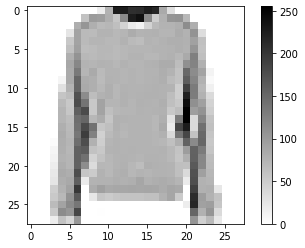

In [ ]:
#Esto no compete con inteligencia artificial pero nos permite ver una imagen
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos después

import matplotlib.pyplot as plt

#ahora si a dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()



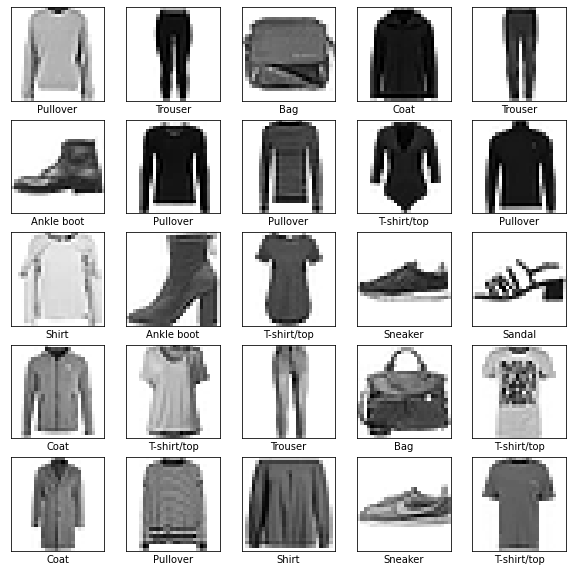

In [ ]:
#Podemos imprimir cada imagen y que nos diga con qué categoría está etiquetada
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombre_clases[etiqueta])
plt.show()

In [ ]:
#Creamos modelo por medio de una red Secuencial, en esta oportunidad definiremos la entrada por medio del uso del "Flatten"
# nuestra matriz de 28x28 píxeles será aplastada por esta función para lograr la entrada de 784 
modelo = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(28,28,1)), #el 1 es por Blanco y Negro, definimos la entrada
   tf.keras.layers.Dense(200, activation=tf.nn.relu), #definimos una capa intermedia, densa con la activación Relu
   tf.keras.layers.Dense(200, activation=tf.nn.relu), #otra
   tf.keras.layers.Dense(10, activation=tf.nn.softmax) #usamos en la capa de salida la función de activación Softmax que es
  #la que se usa siempre en las redes de clasificación, para asegurar que los valores de salida de 1 en suma (nos da el valor más alto)

])

Ej SOFTMAX. Aca un ejemplo de cómo puede prever algo, nos devolverá "Camiseta" pero vemos como la suma de todas las posibilidades da 1 y vemos la mayor

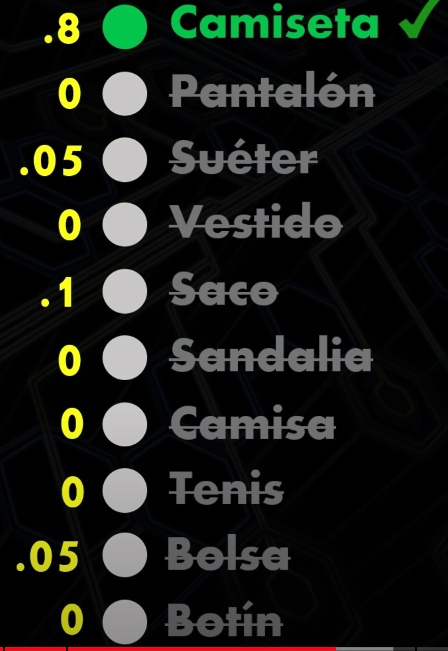

In [ ]:
#ahora si compilamos, utilizaremos nuevamente "Adam" y en la función de pérdida "SparseCategoricalCrossentropy" que también es
#frecuente en algoritmos de clasificación
modelo.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_prueba = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_prueba)

60000
10000


entrenar una red con 7 ejemplos es algo fácil como el caso posterior, ahora que tenemos 70 mil podemos realizar un entrenamiento por lote

In [ ]:
#definimos tamaño de lote
tamano_lote = 32
#ahora ajustamos propiedades, como daremos varias vueltas a los datos le pediremos que repita y que sean aleatorios, en el shuffle
#en lugar de poner "60000" utilizamos el numero de datos de entrenamiento "num_ej_entrenamiento"
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(tamano_lote)
#con los datos de pruebas solo usaremos el .batch()
datos_pruebas = datos_pruebas.batch(tamano_lote)

In [ ]:
#ahora si a entrenar al modelo, utilizaremos el método .fit
import math
#recordemos que en fit(especificamos los taros, epoch= qué cantidad de vuelta le va a dar a los datos, steps_per_epoch= pasos por cada vuelta lo analiza por lotes)
historial = modelo.fit(datos_entrenamiento, epochs=8, steps_per_epoch= math.ceil(num_ej_entrenamiento/tamano_lote))


Epoch 1/8
1875/1875 [==============================] - 11s 3ms/step - loss: 1.8475 - accuracy: 0.7413
Epoch 2/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6478 - accuracy: 0.7872
Epoch 3/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6120 - accuracy: 0.8000
Epoch 4/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5361 - accuracy: 0.8188
Epoch 5/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4941 - accuracy: 0.8285
Epoch 6/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4327 - accuracy: 0.8450
Epoch 7/8
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4266 - accuracy: 0.8475
Epoch 8/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4035 - accuracy: 0.8551


en cada "Vuelta" a los datos podemos ver el Accuracy que sería la precisión, idealmente tendríamos que terminar con un 88% más o menos.
En este caso todavía estamos lejos


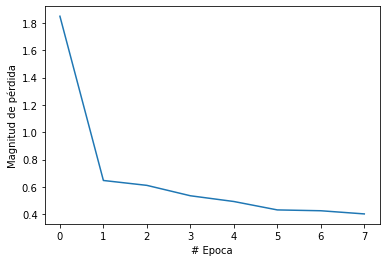

In [ ]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

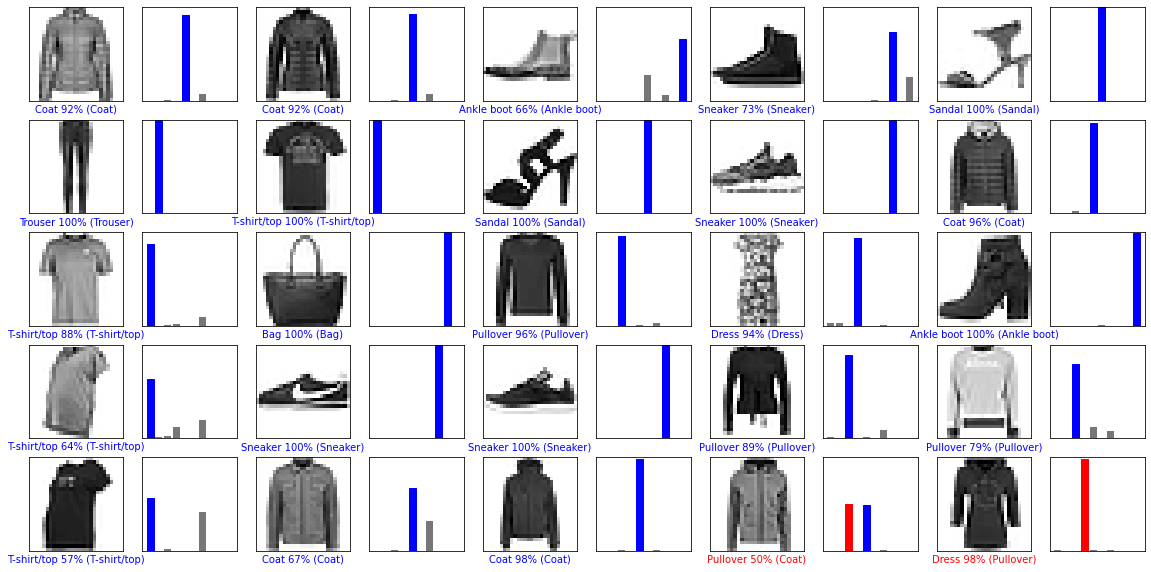

In [ ]:
#Este código no es de AI, pero nos sirve para imprimir 25 elementos del set de prueba y que nuestra red neuronal intente predecir
#Pintar una cuadrícula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)

import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombre_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombre_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [ ]:
#Podemos imprimir la predicción de cualquier índice del set que queramos
imagen = imagenes_prueba[3]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)
print("La Prediccion es: ", nombre_clases[np.argmax(prediccion[0])])

La Prediccion es:  Sneaker


In [ ]:
#Exportando el modelo
modelo.save("RedNeuronal_2.h5")